In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

args = edict({
    'img_size': 128,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/ot/data/dtd2shoes_train',
    'val_img_dir': '/cache/selikhanovych/ot/data/dtd2shoes_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': '/cache/selikhanovych/ot/checkpoints/stargan-v2/stargan-v2/dtd_shoes_128/checkpoints',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'shoes',
    'OUTPUT_PATH': '/cache/selikhanovych/ot/checkpoints/stargan-v2/dtd_shoes_128',
    'domains': {
        'source': 'dtd',
        'target': 'shoes',
    },
    'train_a': '/cache/selikhanovych/ot/data/dtd2shoes_train_dtd',
    'train_b': '/cache/selikhanovych/ot/data/dtd2shoes_train_shoes', 
    'test_a': '/cache/selikhanovych/ot/data/dtd2shoes_test_dtd',
    'test_b': '/cache/selikhanovych/ot/data/dtd2shoes_test_shoes',
    
    'n_epochs': 50
})


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)
print(domains)

1 0
['dtd', 'shoes']


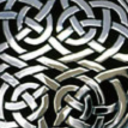

In [2]:
from PIL import Image
from glob import glob

path_to_image = "/cache/selikhanovych/ot/data/dtd2shoes_train/dtd"
images = glob(os.path.join(path_to_image, "*"))

Image.open(images[100])

In [3]:
cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)
assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains
loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

Number of parameters of generator: 33632003
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20799744
Number of parameters of discriminator: 20735106
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...


Computing FID


  0%|          | 0/16 [00:00<?, ?it/s]

Calculating evaluation metrics...
Number of domains: 2
Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


  0%|          | 0/16 [00:00<?, ?it/s]

Compute FID for dtd2shoes
Preparing DataLoader for the generation phase...


100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


FID = 43.71064455601385, best FID = 50.51838445013087, best iter = 20000
Plotting, iter = 24000
mode = train


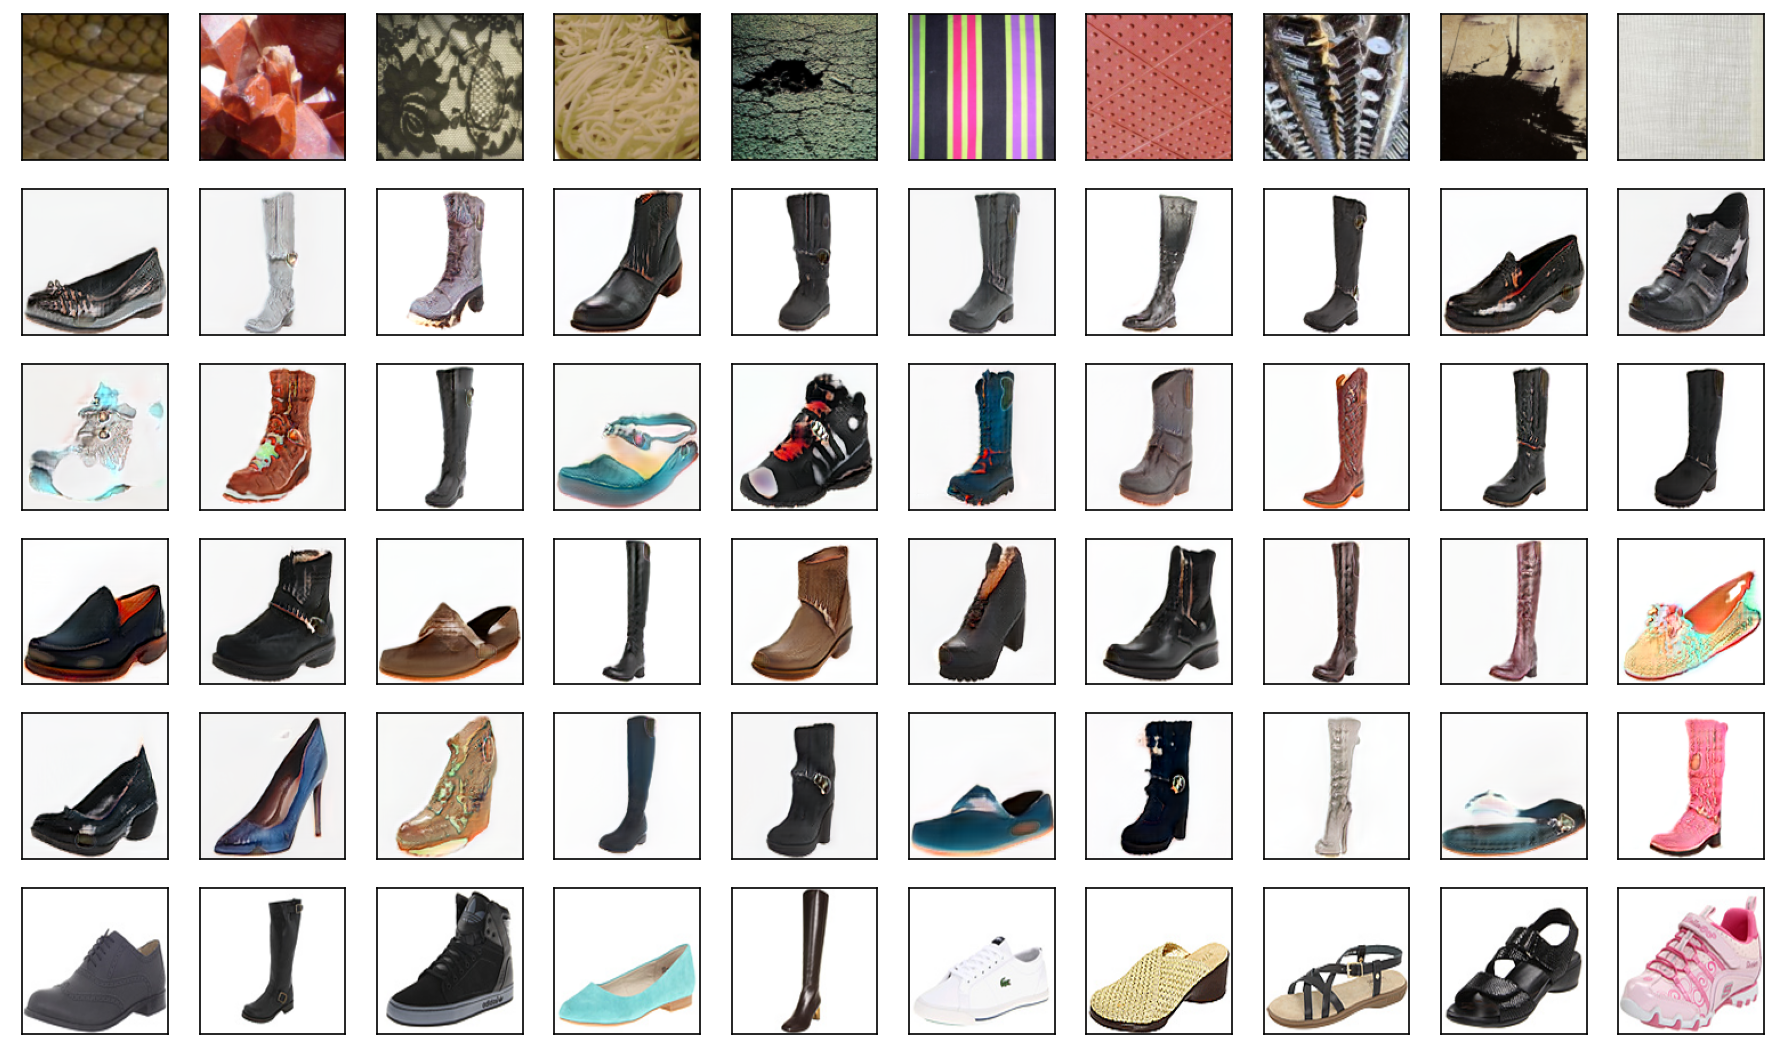

mode = test


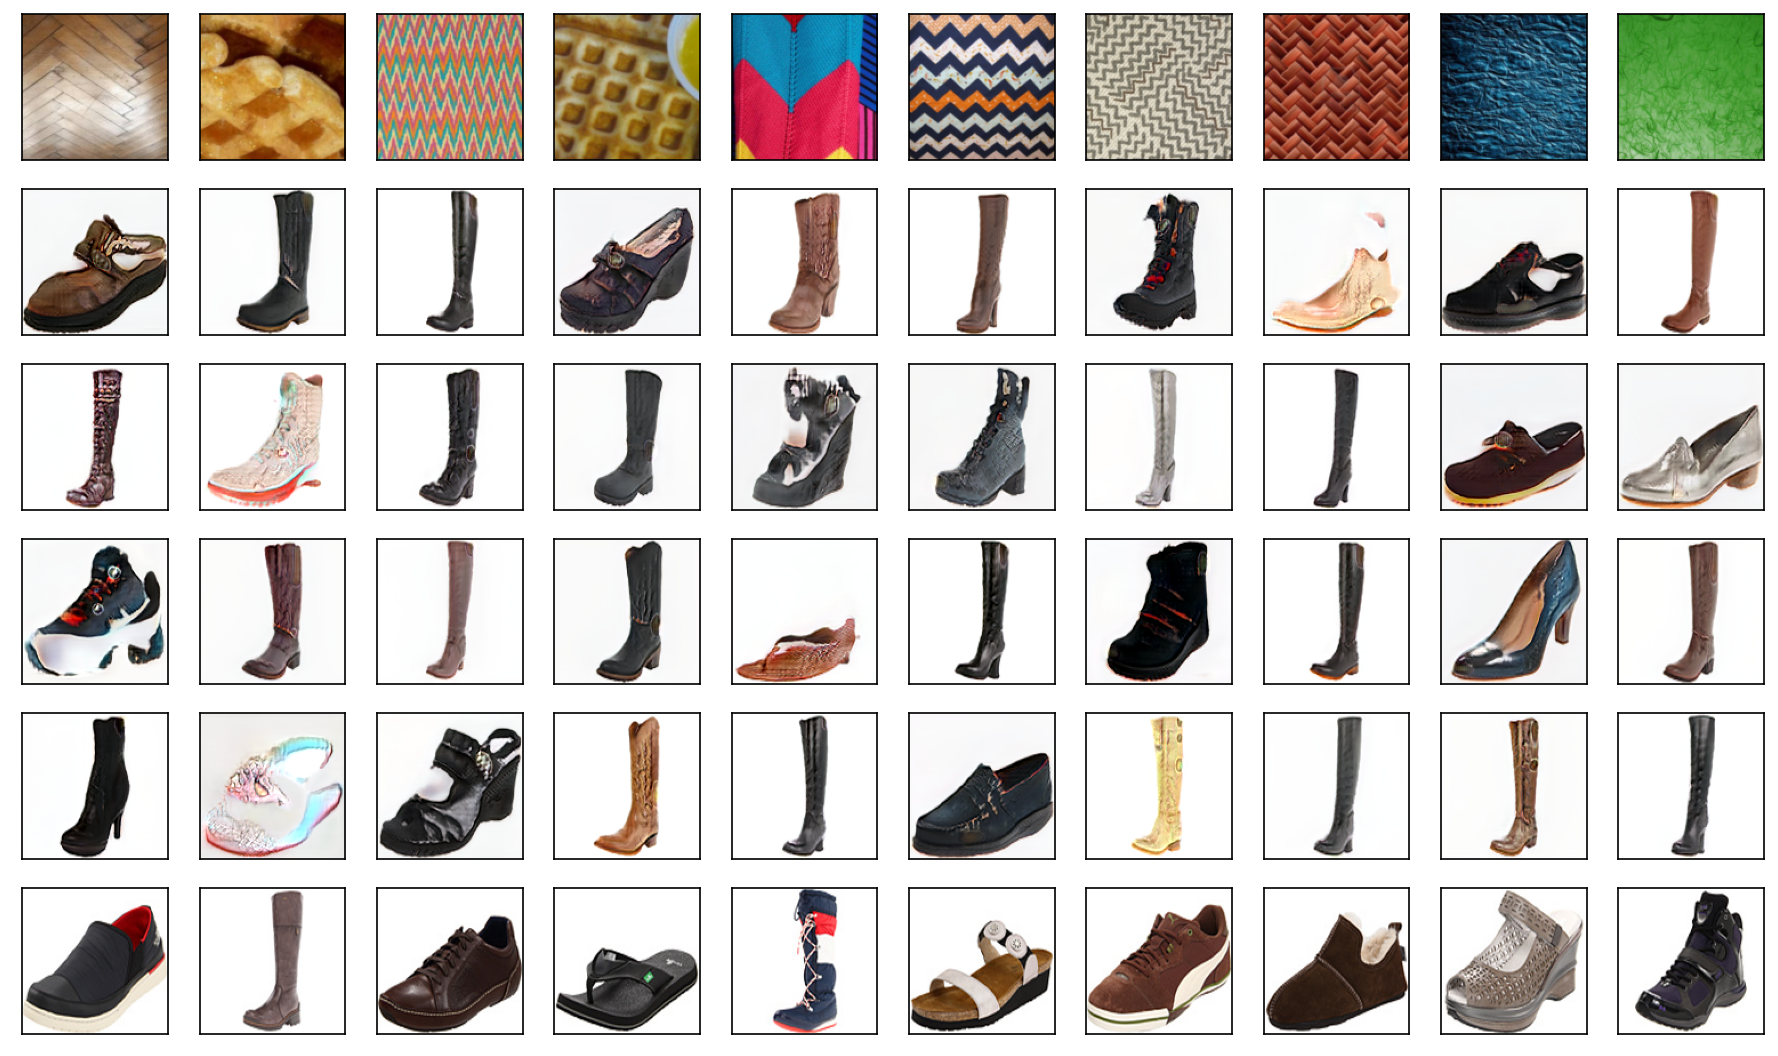

Elapsed time [21:14:12], Iteration [24011/100000], D/latent_real: [0.7374] D/latent_fake: [0.3097] D/latent_reg: [0.1092] D/ref_real: [0.1713] D/ref_fake: [0.2457] D/ref_reg: [0.1074] G/latent_adv: [2.5795] G/latent_sty: [0.2927] G/latent_ds: [0.4304] G/latent_cyc: [0.1868] G/ref_adv: [2.1887] G/ref_sty: [0.1638] G/ref_ds: [0.4462] G/ref_cyc: [0.1818] G/lambda_ds: [0.7599]
Elapsed time [21:14:43], Iteration [24021/100000], D/latent_real: [0.5791] D/latent_fake: [0.2744] D/latent_reg: [0.0941] D/ref_real: [0.1415] D/ref_fake: [0.2490] D/ref_reg: [0.0820] G/latent_adv: [2.9752] G/latent_sty: [0.2889] G/latent_ds: [0.3832] G/latent_cyc: [0.2197] G/ref_adv: [2.4127] G/ref_sty: [0.1566] G/ref_ds: [0.4880] G/ref_cyc: [0.2164] G/lambda_ds: [0.7598]
Elapsed time [21:15:18], Iteration [24031/100000], D/latent_real: [0.3785] D/latent_fake: [0.3113] D/latent_reg: [0.0946] D/ref_real: [0.0763] D/ref_fake: [0.3092] D/ref_reg: [0.0659] G/latent_adv: [2.3369] G/latent_sty: [0.2840] G/latent_ds: [0.37

Elapsed time [21:26:17], Iteration [24231/100000], D/latent_real: [0.4906] D/latent_fake: [0.1829] D/latent_reg: [0.1117] D/ref_real: [0.0686] D/ref_fake: [0.2296] D/ref_reg: [0.0788] G/latent_adv: [2.6368] G/latent_sty: [0.2748] G/latent_ds: [0.4540] G/latent_cyc: [0.2476] G/ref_adv: [2.6817] G/ref_sty: [0.1655] G/ref_ds: [0.5516] G/ref_cyc: [0.2378] G/lambda_ds: [0.7577]
Elapsed time [21:26:50], Iteration [24241/100000], D/latent_real: [0.5812] D/latent_fake: [0.2254] D/latent_reg: [0.1591] D/ref_real: [0.0475] D/ref_fake: [0.3646] D/ref_reg: [0.0977] G/latent_adv: [2.2266] G/latent_sty: [0.2844] G/latent_ds: [0.4547] G/latent_cyc: [0.2346] G/ref_adv: [2.4026] G/ref_sty: [0.1456] G/ref_ds: [0.4919] G/ref_cyc: [0.2295] G/lambda_ds: [0.7576]
Elapsed time [21:27:22], Iteration [24251/100000], D/latent_real: [0.4584] D/latent_fake: [0.2723] D/latent_reg: [0.1162] D/ref_real: [0.0967] D/ref_fake: [0.2043] D/ref_reg: [0.1064] G/latent_adv: [2.6027] G/latent_sty: [0.3325] G/latent_ds: [0.56

Elapsed time [21:38:11], Iteration [24451/100000], D/latent_real: [0.5739] D/latent_fake: [0.2015] D/latent_reg: [0.1401] D/ref_real: [0.0637] D/ref_fake: [0.5744] D/ref_reg: [0.1185] G/latent_adv: [2.5957] G/latent_sty: [0.2831] G/latent_ds: [0.5145] G/latent_cyc: [0.1717] G/ref_adv: [2.8433] G/ref_sty: [0.1753] G/ref_ds: [0.5778] G/ref_cyc: [0.1747] G/lambda_ds: [0.7555]
Elapsed time [21:38:44], Iteration [24461/100000], D/latent_real: [0.5300] D/latent_fake: [0.2639] D/latent_reg: [0.1315] D/ref_real: [0.1321] D/ref_fake: [0.3460] D/ref_reg: [0.1226] G/latent_adv: [2.9502] G/latent_sty: [0.3122] G/latent_ds: [0.5347] G/latent_cyc: [0.2433] G/ref_adv: [2.5924] G/ref_sty: [0.1348] G/ref_ds: [0.4721] G/ref_cyc: [0.2379] G/lambda_ds: [0.7554]
Elapsed time [21:39:16], Iteration [24471/100000], D/latent_real: [0.8674] D/latent_fake: [0.2505] D/latent_reg: [0.1346] D/ref_real: [0.1798] D/ref_fake: [0.2298] D/ref_reg: [0.1192] G/latent_adv: [2.6240] G/latent_sty: [0.2638] G/latent_ds: [0.46

Elapsed time [21:49:58], Iteration [24671/100000], D/latent_real: [0.4585] D/latent_fake: [0.2036] D/latent_reg: [0.1270] D/ref_real: [0.0611] D/ref_fake: [0.2520] D/ref_reg: [0.1068] G/latent_adv: [2.5622] G/latent_sty: [0.2816] G/latent_ds: [0.4927] G/latent_cyc: [0.2011] G/ref_adv: [2.4356] G/ref_sty: [0.2077] G/ref_ds: [0.4452] G/ref_cyc: [0.1866] G/lambda_ds: [0.7533]
Elapsed time [21:50:31], Iteration [24681/100000], D/latent_real: [0.6862] D/latent_fake: [0.3093] D/latent_reg: [0.1254] D/ref_real: [0.1956] D/ref_fake: [0.2327] D/ref_reg: [0.1032] G/latent_adv: [2.5354] G/latent_sty: [0.2946] G/latent_ds: [0.4197] G/latent_cyc: [0.1968] G/ref_adv: [2.0485] G/ref_sty: [0.1933] G/ref_ds: [0.4090] G/ref_cyc: [0.2029] G/lambda_ds: [0.7532]
Elapsed time [21:51:04], Iteration [24691/100000], D/latent_real: [0.8929] D/latent_fake: [0.2073] D/latent_reg: [0.1193] D/ref_real: [0.1541] D/ref_fake: [0.4803] D/ref_reg: [0.0379] G/latent_adv: [1.6163] G/latent_sty: [0.3022] G/latent_ds: [0.40

Elapsed time [22:01:10], Iteration [24891/100000], D/latent_real: [0.7137] D/latent_fake: [0.1693] D/latent_reg: [0.1295] D/ref_real: [0.0465] D/ref_fake: [0.4606] D/ref_reg: [0.0698] G/latent_adv: [2.2464] G/latent_sty: [0.2963] G/latent_ds: [0.4497] G/latent_cyc: [0.1744] G/ref_adv: [2.5345] G/ref_sty: [0.2356] G/ref_ds: [0.5092] G/ref_cyc: [0.1801] G/lambda_ds: [0.7511]
Elapsed time [22:01:27], Iteration [24901/100000], D/latent_real: [0.8393] D/latent_fake: [0.1448] D/latent_reg: [0.1181] D/ref_real: [0.2449] D/ref_fake: [0.2954] D/ref_reg: [0.0725] G/latent_adv: [2.2089] G/latent_sty: [0.2831] G/latent_ds: [0.4638] G/latent_cyc: [0.2177] G/ref_adv: [2.1646] G/ref_sty: [0.1334] G/ref_ds: [0.4080] G/ref_cyc: [0.2098] G/lambda_ds: [0.7510]
Elapsed time [22:01:56], Iteration [24911/100000], D/latent_real: [0.5035] D/latent_fake: [0.1657] D/latent_reg: [0.1194] D/ref_real: [0.0265] D/ref_fake: [0.3506] D/ref_reg: [0.0746] G/latent_adv: [2.6367] G/latent_sty: [0.3064] G/latent_ds: [0.44

Elapsed time [22:12:47], Iteration [25111/100000], D/latent_real: [0.6753] D/latent_fake: [0.3263] D/latent_reg: [0.1664] D/ref_real: [0.1527] D/ref_fake: [0.4165] D/ref_reg: [0.0869] G/latent_adv: [2.3925] G/latent_sty: [0.2917] G/latent_ds: [0.4567] G/latent_cyc: [0.1966] G/ref_adv: [2.1062] G/ref_sty: [0.1447] G/ref_ds: [0.5433] G/ref_cyc: [0.1912] G/lambda_ds: [0.7489]
Elapsed time [22:13:21], Iteration [25121/100000], D/latent_real: [0.4727] D/latent_fake: [0.3126] D/latent_reg: [0.0787] D/ref_real: [0.1334] D/ref_fake: [0.4372] D/ref_reg: [0.1120] G/latent_adv: [2.7400] G/latent_sty: [0.3112] G/latent_ds: [0.5146] G/latent_cyc: [0.1716] G/ref_adv: [2.6946] G/ref_sty: [0.1598] G/ref_ds: [0.4101] G/ref_cyc: [0.1646] G/lambda_ds: [0.7488]
Elapsed time [22:13:54], Iteration [25131/100000], D/latent_real: [0.5203] D/latent_fake: [0.1355] D/latent_reg: [0.1297] D/ref_real: [0.0534] D/ref_fake: [0.3428] D/ref_reg: [0.1086] G/latent_adv: [2.5530] G/latent_sty: [0.2612] G/latent_ds: [0.43

Elapsed time [22:24:40], Iteration [25331/100000], D/latent_real: [0.4746] D/latent_fake: [0.1152] D/latent_reg: [0.1327] D/ref_real: [0.0324] D/ref_fake: [0.3603] D/ref_reg: [0.0515] G/latent_adv: [2.1389] G/latent_sty: [0.2492] G/latent_ds: [0.4472] G/latent_cyc: [0.2220] G/ref_adv: [2.5822] G/ref_sty: [0.1375] G/ref_ds: [0.5024] G/ref_cyc: [0.2237] G/lambda_ds: [0.7467]
Elapsed time [22:25:13], Iteration [25341/100000], D/latent_real: [0.3950] D/latent_fake: [0.2901] D/latent_reg: [0.1167] D/ref_real: [0.1362] D/ref_fake: [0.3066] D/ref_reg: [0.1159] G/latent_adv: [3.1176] G/latent_sty: [0.2953] G/latent_ds: [0.5635] G/latent_cyc: [0.2012] G/ref_adv: [2.7166] G/ref_sty: [0.1619] G/ref_ds: [0.5088] G/ref_cyc: [0.1950] G/lambda_ds: [0.7466]
Elapsed time [22:25:45], Iteration [25351/100000], D/latent_real: [0.7958] D/latent_fake: [0.1073] D/latent_reg: [0.1507] D/ref_real: [0.0371] D/ref_fake: [0.8895] D/ref_reg: [0.0435] G/latent_adv: [1.7118] G/latent_sty: [0.2972] G/latent_ds: [0.42

Elapsed time [22:36:36], Iteration [25551/100000], D/latent_real: [0.6006] D/latent_fake: [0.3654] D/latent_reg: [0.1167] D/ref_real: [0.1433] D/ref_fake: [0.2824] D/ref_reg: [0.0958] G/latent_adv: [2.7832] G/latent_sty: [0.2916] G/latent_ds: [0.4400] G/latent_cyc: [0.1946] G/ref_adv: [2.3178] G/ref_sty: [0.1562] G/ref_ds: [0.4485] G/ref_cyc: [0.1808] G/lambda_ds: [0.7445]
Elapsed time [22:37:09], Iteration [25561/100000], D/latent_real: [0.2195] D/latent_fake: [0.2147] D/latent_reg: [0.0964] D/ref_real: [0.0836] D/ref_fake: [0.2146] D/ref_reg: [0.1092] G/latent_adv: [3.4396] G/latent_sty: [0.3046] G/latent_ds: [0.5587] G/latent_cyc: [0.2856] G/ref_adv: [2.7088] G/ref_sty: [0.1381] G/ref_ds: [0.4814] G/ref_cyc: [0.2771] G/lambda_ds: [0.7444]
Elapsed time [22:37:42], Iteration [25571/100000], D/latent_real: [0.5942] D/latent_fake: [0.3146] D/latent_reg: [0.1485] D/ref_real: [0.1593] D/ref_fake: [0.3538] D/ref_reg: [0.1526] G/latent_adv: [2.8864] G/latent_sty: [0.2640] G/latent_ds: [0.53

Elapsed time [22:48:33], Iteration [25771/100000], D/latent_real: [0.6390] D/latent_fake: [0.1861] D/latent_reg: [0.0931] D/ref_real: [0.1619] D/ref_fake: [0.3247] D/ref_reg: [0.0769] G/latent_adv: [2.4672] G/latent_sty: [0.2989] G/latent_ds: [0.4841] G/latent_cyc: [0.1548] G/ref_adv: [2.3102] G/ref_sty: [0.1784] G/ref_ds: [0.3896] G/ref_cyc: [0.1521] G/lambda_ds: [0.7423]
Elapsed time [22:49:08], Iteration [25781/100000], D/latent_real: [0.3091] D/latent_fake: [0.3224] D/latent_reg: [0.0850] D/ref_real: [0.0905] D/ref_fake: [0.2080] D/ref_reg: [0.0838] G/latent_adv: [3.4597] G/latent_sty: [0.3018] G/latent_ds: [0.4832] G/latent_cyc: [0.2454] G/ref_adv: [2.6476] G/ref_sty: [0.1378] G/ref_ds: [0.4780] G/ref_cyc: [0.2339] G/lambda_ds: [0.7422]
Elapsed time [22:49:40], Iteration [25791/100000], D/latent_real: [0.7158] D/latent_fake: [0.1957] D/latent_reg: [0.1493] D/ref_real: [0.2062] D/ref_fake: [0.3177] D/ref_reg: [0.1064] G/latent_adv: [2.3969] G/latent_sty: [0.2975] G/latent_ds: [0.45

Elapsed time [23:00:27], Iteration [25991/100000], D/latent_real: [0.6677] D/latent_fake: [0.3684] D/latent_reg: [0.0955] D/ref_real: [0.1510] D/ref_fake: [0.5472] D/ref_reg: [0.0925] G/latent_adv: [2.5986] G/latent_sty: [0.2653] G/latent_ds: [0.4452] G/latent_cyc: [0.1809] G/ref_adv: [2.3920] G/ref_sty: [0.1464] G/ref_ds: [0.4357] G/ref_cyc: [0.1753] G/lambda_ds: [0.7401]
Elapsed time [23:01:01], Iteration [26001/100000], D/latent_real: [0.7672] D/latent_fake: [0.2172] D/latent_reg: [0.1207] D/ref_real: [0.0989] D/ref_fake: [0.4696] D/ref_reg: [0.0408] G/latent_adv: [1.9786] G/latent_sty: [0.3017] G/latent_ds: [0.4409] G/latent_cyc: [0.1750] G/ref_adv: [2.1330] G/ref_sty: [0.1596] G/ref_ds: [0.5521] G/ref_cyc: [0.1734] G/lambda_ds: [0.7400]
Elapsed time [23:01:32], Iteration [26011/100000], D/latent_real: [0.8571] D/latent_fake: [0.2214] D/latent_reg: [0.1111] D/ref_real: [0.1300] D/ref_fake: [0.2485] D/ref_reg: [0.0843] G/latent_adv: [2.0943] G/latent_sty: [0.2728] G/latent_ds: [0.52

Elapsed time [23:12:16], Iteration [26211/100000], D/latent_real: [0.8941] D/latent_fake: [0.1901] D/latent_reg: [0.0975] D/ref_real: [0.1510] D/ref_fake: [0.3614] D/ref_reg: [0.0635] G/latent_adv: [2.2403] G/latent_sty: [0.2842] G/latent_ds: [0.5201] G/latent_cyc: [0.1868] G/ref_adv: [2.2136] G/ref_sty: [0.1384] G/ref_ds: [0.3972] G/ref_cyc: [0.1786] G/lambda_ds: [0.7379]
Elapsed time [23:12:49], Iteration [26221/100000], D/latent_real: [0.8102] D/latent_fake: [0.3853] D/latent_reg: [0.1261] D/ref_real: [0.2367] D/ref_fake: [0.3357] D/ref_reg: [0.0944] G/latent_adv: [2.5994] G/latent_sty: [0.3264] G/latent_ds: [0.4830] G/latent_cyc: [0.1931] G/ref_adv: [2.0393] G/ref_sty: [0.1436] G/ref_ds: [0.3954] G/ref_cyc: [0.1869] G/lambda_ds: [0.7378]
Elapsed time [23:13:22], Iteration [26231/100000], D/latent_real: [0.8274] D/latent_fake: [0.2442] D/latent_reg: [0.1044] D/ref_real: [0.0906] D/ref_fake: [0.5732] D/ref_reg: [0.0728] G/latent_adv: [2.2218] G/latent_sty: [0.2410] G/latent_ds: [0.43

Elapsed time [23:24:11], Iteration [26431/100000], D/latent_real: [0.4810] D/latent_fake: [0.1877] D/latent_reg: [0.1397] D/ref_real: [0.0929] D/ref_fake: [0.3003] D/ref_reg: [0.1010] G/latent_adv: [3.0057] G/latent_sty: [0.2834] G/latent_ds: [0.4811] G/latent_cyc: [0.2169] G/ref_adv: [2.5329] G/ref_sty: [0.1668] G/ref_ds: [0.5185] G/ref_cyc: [0.2077] G/lambda_ds: [0.7357]
Elapsed time [23:24:45], Iteration [26441/100000], D/latent_real: [0.5886] D/latent_fake: [0.2167] D/latent_reg: [0.1398] D/ref_real: [0.1162] D/ref_fake: [0.5093] D/ref_reg: [0.1063] G/latent_adv: [2.4047] G/latent_sty: [0.2870] G/latent_ds: [0.3815] G/latent_cyc: [0.1936] G/ref_adv: [2.7257] G/ref_sty: [0.1430] G/ref_ds: [0.4525] G/ref_cyc: [0.1846] G/lambda_ds: [0.7356]
Elapsed time [23:25:18], Iteration [26451/100000], D/latent_real: [0.5647] D/latent_fake: [0.4725] D/latent_reg: [0.1042] D/ref_real: [0.2421] D/ref_fake: [0.2766] D/ref_reg: [0.0938] G/latent_adv: [3.0574] G/latent_sty: [0.2521] G/latent_ds: [0.53

Elapsed time [23:36:09], Iteration [26651/100000], D/latent_real: [0.7056] D/latent_fake: [0.1355] D/latent_reg: [0.1148] D/ref_real: [0.0762] D/ref_fake: [0.4434] D/ref_reg: [0.0900] G/latent_adv: [3.0884] G/latent_sty: [0.2666] G/latent_ds: [0.4028] G/latent_cyc: [0.2189] G/ref_adv: [2.9819] G/ref_sty: [0.1670] G/ref_ds: [0.4420] G/ref_cyc: [0.2043] G/lambda_ds: [0.7335]
Elapsed time [23:36:44], Iteration [26661/100000], D/latent_real: [0.5175] D/latent_fake: [0.3733] D/latent_reg: [0.0940] D/ref_real: [0.1954] D/ref_fake: [0.2632] D/ref_reg: [0.1032] G/latent_adv: [2.6358] G/latent_sty: [0.3221] G/latent_ds: [0.5193] G/latent_cyc: [0.2154] G/ref_adv: [1.8807] G/ref_sty: [0.1348] G/ref_ds: [0.4226] G/ref_cyc: [0.2069] G/lambda_ds: [0.7334]
Elapsed time [23:37:15], Iteration [26671/100000], D/latent_real: [0.8189] D/latent_fake: [0.2083] D/latent_reg: [0.1274] D/ref_real: [0.1087] D/ref_fake: [0.6450] D/ref_reg: [0.0777] G/latent_adv: [2.2177] G/latent_sty: [0.3290] G/latent_ds: [0.46

Elapsed time [23:47:11], Iteration [26871/100000], D/latent_real: [0.2334] D/latent_fake: [0.2614] D/latent_reg: [0.0833] D/ref_real: [0.0696] D/ref_fake: [0.1893] D/ref_reg: [0.1015] G/latent_adv: [3.2255] G/latent_sty: [0.3072] G/latent_ds: [0.4309] G/latent_cyc: [0.2583] G/ref_adv: [2.5685] G/ref_sty: [0.1438] G/ref_ds: [0.4645] G/ref_cyc: [0.2471] G/lambda_ds: [0.7313]
Elapsed time [23:47:44], Iteration [26881/100000], D/latent_real: [0.4792] D/latent_fake: [0.3543] D/latent_reg: [0.1166] D/ref_real: [0.1774] D/ref_fake: [0.2983] D/ref_reg: [0.1185] G/latent_adv: [3.3594] G/latent_sty: [0.2810] G/latent_ds: [0.5541] G/latent_cyc: [0.2253] G/ref_adv: [2.4488] G/ref_sty: [0.1681] G/ref_ds: [0.4280] G/ref_cyc: [0.2109] G/lambda_ds: [0.7312]
Elapsed time [23:48:16], Iteration [26891/100000], D/latent_real: [0.4304] D/latent_fake: [0.4018] D/latent_reg: [0.1036] D/ref_real: [0.1728] D/ref_fake: [0.3509] D/ref_reg: [0.1054] G/latent_adv: [2.7404] G/latent_sty: [0.3057] G/latent_ds: [0.47

Elapsed time [23:58:59], Iteration [27091/100000], D/latent_real: [0.6629] D/latent_fake: [0.4453] D/latent_reg: [0.0913] D/ref_real: [0.2813] D/ref_fake: [0.2019] D/ref_reg: [0.0735] G/latent_adv: [2.9561] G/latent_sty: [0.2910] G/latent_ds: [0.4516] G/latent_cyc: [0.2012] G/ref_adv: [2.0659] G/ref_sty: [0.1511] G/ref_ds: [0.4614] G/ref_cyc: [0.2021] G/lambda_ds: [0.7291]
Elapsed time [23:59:32], Iteration [27101/100000], D/latent_real: [0.2621] D/latent_fake: [0.3895] D/latent_reg: [0.1510] D/ref_real: [0.0569] D/ref_fake: [0.2563] D/ref_reg: [0.1075] G/latent_adv: [3.4641] G/latent_sty: [0.3111] G/latent_ds: [0.5049] G/latent_cyc: [0.2631] G/ref_adv: [2.9221] G/ref_sty: [0.1695] G/ref_ds: [0.4303] G/ref_cyc: [0.2505] G/lambda_ds: [0.7290]
Elapsed time [1 day, 0:00:05], Iteration [27111/100000], D/latent_real: [0.6011] D/latent_fake: [0.4385] D/latent_reg: [0.1216] D/ref_real: [0.2180] D/ref_fake: [0.1820] D/ref_reg: [0.1092] G/latent_adv: [2.7840] G/latent_sty: [0.2760] G/latent_ds:

Elapsed time [1 day, 0:10:56], Iteration [27311/100000], D/latent_real: [0.5715] D/latent_fake: [0.1475] D/latent_reg: [0.1571] D/ref_real: [0.0544] D/ref_fake: [0.3343] D/ref_reg: [0.1116] G/latent_adv: [2.7007] G/latent_sty: [0.3018] G/latent_ds: [0.5351] G/latent_cyc: [0.2236] G/ref_adv: [2.4667] G/ref_sty: [0.1786] G/ref_ds: [0.5195] G/ref_cyc: [0.2455] G/lambda_ds: [0.7269]
Elapsed time [1 day, 0:11:27], Iteration [27321/100000], D/latent_real: [0.3862] D/latent_fake: [0.4044] D/latent_reg: [0.0907] D/ref_real: [0.2414] D/ref_fake: [0.1616] D/ref_reg: [0.1076] G/latent_adv: [2.7496] G/latent_sty: [0.2906] G/latent_ds: [0.4635] G/latent_cyc: [0.2188] G/ref_adv: [2.1938] G/ref_sty: [0.1507] G/ref_ds: [0.5535] G/ref_cyc: [0.2214] G/lambda_ds: [0.7268]
Elapsed time [1 day, 0:12:00], Iteration [27331/100000], D/latent_real: [0.4347] D/latent_fake: [0.3368] D/latent_reg: [0.1257] D/ref_real: [0.0637] D/ref_fake: [0.4074] D/ref_reg: [0.1316] G/latent_adv: [2.9537] G/latent_sty: [0.2639] 

Elapsed time [1 day, 0:22:50], Iteration [27531/100000], D/latent_real: [0.2090] D/latent_fake: [0.3225] D/latent_reg: [0.1221] D/ref_real: [0.0697] D/ref_fake: [0.2352] D/ref_reg: [0.1207] G/latent_adv: [3.2331] G/latent_sty: [0.2919] G/latent_ds: [0.4723] G/latent_cyc: [0.2640] G/ref_adv: [2.6760] G/ref_sty: [0.1496] G/ref_ds: [0.4286] G/ref_cyc: [0.2604] G/lambda_ds: [0.7247]
Elapsed time [1 day, 0:23:22], Iteration [27541/100000], D/latent_real: [0.9557] D/latent_fake: [0.2056] D/latent_reg: [0.1250] D/ref_real: [0.1919] D/ref_fake: [0.3142] D/ref_reg: [0.0943] G/latent_adv: [2.5044] G/latent_sty: [0.3056] G/latent_ds: [0.4504] G/latent_cyc: [0.1840] G/ref_adv: [1.9957] G/ref_sty: [0.1352] G/ref_ds: [0.5717] G/ref_cyc: [0.1785] G/lambda_ds: [0.7246]
Elapsed time [1 day, 0:23:54], Iteration [27551/100000], D/latent_real: [0.5776] D/latent_fake: [0.3960] D/latent_reg: [0.1314] D/ref_real: [0.1253] D/ref_fake: [0.3124] D/ref_reg: [0.0472] G/latent_adv: [2.1702] G/latent_sty: [0.2763] 

Elapsed time [1 day, 0:34:44], Iteration [27751/100000], D/latent_real: [0.3923] D/latent_fake: [0.3898] D/latent_reg: [0.1557] D/ref_real: [0.1510] D/ref_fake: [0.2987] D/ref_reg: [0.1366] G/latent_adv: [3.2137] G/latent_sty: [0.2827] G/latent_ds: [0.4580] G/latent_cyc: [0.2399] G/ref_adv: [2.2379] G/ref_sty: [0.1383] G/ref_ds: [0.4810] G/ref_cyc: [0.2310] G/lambda_ds: [0.7225]
Elapsed time [1 day, 0:35:15], Iteration [27761/100000], D/latent_real: [0.5533] D/latent_fake: [0.2043] D/latent_reg: [0.0925] D/ref_real: [0.1054] D/ref_fake: [0.5409] D/ref_reg: [0.0729] G/latent_adv: [2.5300] G/latent_sty: [0.2766] G/latent_ds: [0.4611] G/latent_cyc: [0.2178] G/ref_adv: [2.6181] G/ref_sty: [0.1581] G/ref_ds: [0.5524] G/ref_cyc: [0.2083] G/lambda_ds: [0.7224]
Elapsed time [1 day, 0:35:49], Iteration [27771/100000], D/latent_real: [0.3804] D/latent_fake: [0.4352] D/latent_reg: [0.0647] D/ref_real: [0.2306] D/ref_fake: [0.3124] D/ref_reg: [0.0688] G/latent_adv: [2.6904] G/latent_sty: [0.2834] 

In [ ]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        print('Computing FID')
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for i in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[i][j]

                    axes[i + 1][j].imshow(cur_img)
                    axes[i + 1][j].get_xaxis().set_visible(False)
                    axes[i + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()